In [2]:
import cv2
import numpy as np
import time
from scipy.optimize import least_squares
import math
import matplotlib.pyplot as plt
from utils import non_max_suppression
import os
import glob

In [3]:

def euclidean_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

def ajustar_circulo(puntos):
    """
    Ajusta un círculo a los puntos dados
    """
    def residuo(params, puntos):
        cx, cy, r = params
        return [np.sqrt((x - cx)**2 + (y - cy)**2) - r for x, y in puntos]

    # Inicialización: Centro aproximado y radio promedio
    x_mean, y_mean = np.mean(puntos, axis=0)
    r_init = np.mean([np.sqrt((x - x_mean)**2 + (y - y_mean)**2) for x, y in puntos])
    params_iniciales = [x_mean, y_mean, r_init]

    # Ajustar el círculo
    resultado = least_squares(residuo, params_iniciales, args=(puntos,))
    cx, cy, r = resultado.x
    return cx, cy, r

def generar_puntos_circulo(cx, cy, r, n_puntos):
    """
    Genera n_puntos uniformemente distribuidos en el círculo ajustado
    """
    angulos = np.linspace(0, 2 * np.pi, n_puntos, endpoint=False)
    puntos_circulo = [(cx + r * np.sin(theta), cy - r * np.cos(theta)) for theta in angulos]
    return puntos_circulo

def calcular_semejanza_circulo(puntos_originales, puntos_circulo, radio):
    """
    Calcula la semejanza entre los puntos originales y los del círculo ajustado
    """
    #Calcular las distancias entre puntos originales y el más cercano de entre los puntos del círculo ajustado,
    #teniendo en cuenta que cada punto del círculo ajustado solo puede ser emparejado con dos puntos originales
    distancias = []
    puntos_disponibles = puntos_circulo.copy()
    puntos_unidos = {punto: [] for punto in puntos_circulo}
    for punto_orig in puntos_originales:
        distancias_punto = [euclidean_distance(punto_orig, punto_circulo) for punto_circulo in puntos_disponibles]
        distancia_minima = min(distancias_punto)
        distancias.append(distancia_minima)
        punto_cercano = puntos_disponibles[distancias_punto.index(distancia_minima)]
        puntos_unidos[punto_cercano].append(punto_orig)
        if len(puntos_unidos[punto_cercano]) == 2:
            puntos_disponibles.remove(punto_cercano)

    #Elevamos las distancias al cuadrado
    distancias = [distancia**3 for distancia in distancias]
    media_distancia = np.mean(distancias)

    #Calculamos la semejanza
    semejanza = 1 / (1 + media_distancia/((radio**3)/500))

    return semejanza, puntos_unidos



from scipy.spatial import ConvexHull
from itertools import combinations

def distancia_punto_segmento(p, a, b):
    # Convertir a numpy arrays
    p = np.array(p)
    a = np.array(a)
    b = np.array(b)
    
    # Vector del segmento AB
    ab = b - a
    # Vector del punto a P respecto a A
    ap = p - a
    # Longitud al cuadrado del segmento AB
    ab_len_sq = np.dot(ab, ab)
    
    if ab_len_sq == 0:
        # Caso especial: A y B son el mismo punto
        return np.linalg.norm(p - a)
    
    # Proyección escalar de AP sobre AB, limitado al rango [0, 1]
    t = max(0, min(1, np.dot(ap, ab) / ab_len_sq))
    # Coordenadas del punto proyectado sobre el segmento
    proyeccion = a + t * ab
    
    # Distancia del punto P al punto proyectado
    return np.linalg.norm(p - proyeccion)

def error_distancia(triangle, polygon):
    a, b, c = triangle
    error = 0
    for p in polygon:
        error += min(
            distancia_punto_segmento(p, a, b),
            distancia_punto_segmento(p, b, c),
            distancia_punto_segmento(p, c, a)
        )
    return error

def ajustar_triangulo(puntos):
    hull = ConvexHull(puntos)
    vertices = [puntos[i] for i in hull.vertices]

    best_triangle = None
    min_error = float('inf')
    for triangle in combinations(vertices, 3):
        error = error_distancia(triangle, vertices)
        if error < min_error:
            min_error = error
            best_triangle = triangle
    return np.array(best_triangle)


def generar_puntos_triangulo(triangulo, n_puntos):
    """
    Genera n_puntos distribuidos uniformemente en el perímetro del triángulo.
    """
    lados = [np.linalg.norm(triangulo[i] - triangulo[(i + 1) % 3]) for i in range(3)]
    total_largo = sum(lados)
    puntos = []

    for i in range(3):
        p1, p2 = triangulo[i], triangulo[(i + 1) % 3]
        n_lado = int(n_puntos * lados[i] / total_largo)
        for t in np.linspace(0, 1, n_lado + 1, endpoint=False):
            puntos.append(p1 + t * (p2 - p1))

    #Convertir los puntos a tuplas
    puntos = [tuple(punto) for punto in puntos]
    return puntos

def calcular_semejanza_triangulo(puntos_originales, puntos_triangulo):
    """
    Calcula la semejanza usando la media de las distancias.
    """
    distancias = []
    puntos_disponibles = puntos_triangulo.copy()
    puntos_unidos = {punto: [] for punto in puntos_triangulo}
    for punto_orig in puntos_originales:
        distancias_punto = [euclidean_distance(punto_orig, punto_triangulo) for punto_triangulo in puntos_disponibles]
        distancia_minima = min(distancias_punto)
        distancias.append(distancia_minima)
        punto_cercano = puntos_disponibles[distancias_punto.index(distancia_minima)]
        puntos_unidos[punto_cercano].append(punto_orig)
        if len(puntos_unidos[punto_cercano]) == 2:
            puntos_disponibles.remove(punto_cercano)

    #Elevamos las distancias al cuadrado
    distancias = [distancia**3 for distancia in distancias]
    media_distancia = np.mean(distancias)

    #Calculamos la semejanza
    semejanza = 1 / (1 + media_distancia/(10000))

    return semejanza, puntos_unidos


In [4]:
def plot_circulo(puntos_originales, puntos_circulo, puntos_unidos):
    """
    Grafica los puntos originales y los del círculo ajustado
    """
    fig, ax = plt.subplots()

    # Graficar los puntos originales
    x_coords, y_coords = zip(*puntos_originales)
    ax.scatter(x_coords, y_coords, color='blue', label='Puntos originales')

    # Graficar los puntos del círculo ajustado
    x_coords, y_coords = zip(*puntos_circulo)
    ax.scatter(x_coords, y_coords, color='red', label='Puntos modelados')
    #ax.plot(x_coords + x_coords[:1], y_coords + y_coords[:1], color='red', label='Círculo ajustado')

    # Graficar la union entre cada punto original y su punto correspondiente en el círculo ajustado
    for punto_circulo, puntos_originales in puntos_unidos.items():
        for punto_orig in puntos_originales:
            x_coords, y_coords = zip(punto_circulo, punto_orig)
            ax.plot(x_coords, y_coords, color='green')

    # Configuración del gráfico
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ajuste de círculo a los puntos')
    plt.grid()
    plt.show()

def plot_triangulo(puntos_originales, puntos_triangulo, puntos_unidos):
    """
    Grafica los puntos originales y los del triángulo ajustado
    """
    fig, ax = plt.subplots()

    # Graficar los puntos del triángulo ajustado
    x_coords, y_coords = zip(*puntos_triangulo)
    ax.scatter(x_coords, y_coords, color='red', label='Puntos modelados')
    ax.plot(x_coords + x_coords[:1], y_coords + y_coords[:1], color='red', label='Triángulo ajustado')

    # Graficar los puntos originales
    x_coords, y_coords = zip(*puntos_originales)
    ax.scatter(x_coords, y_coords, color='blue', label='Puntos originales')

    # Graficar la union entre cada punto original y su punto correspondiente en el triángulo ajustado
    for punto_triangulo, puntos_originales in puntos_unidos.items():
        for punto_orig in puntos_originales:
            x_coords, y_coords = zip(punto_triangulo, punto_orig)
            ax.plot(x_coords, y_coords, color='green')

    # Configuración del gráfico
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ajuste de triángulo a los puntos')
    plt.grid()
    plt.show()

In [5]:
# Inicializar el filtro de Kalman
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                      [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                     [0, 1, 0, 1],
                                     [0, 0, 1, 0],
                                     [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03


def detect_bright_object(frame):
    """
    Detecta un objeto luminoso en la imagen y devuelve su posición
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Ajustar el rango para detectar brillo (alta saturación y valor)
    lower_bound = np.array([0, 0, 200], dtype=np.uint8)
    upper_bound = np.array([180, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Encontrar contornos del objeto luminoso
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > 50:  # Filtrar pequeños ruidos
            (x, y), _ = cv2.minEnclosingCircle(largest_contour)
            return int(x), int(y)
    return None



In [6]:
# TODO Define the method
def gaussian_blur(img: np.array, sigma: float, filter_shape: None = None, verbose: bool = False) -> np.array:
    # TODO If not given, compute the filter shape 
    if filter_shape == None:
        filter_l = int(2 * sigma) + 1
    else:
        filter_l = filter_shape[0]
    
    # TODO Create the filter coordinates matrices
    y, x = np.mgrid[-filter_l//2 + 1:filter_l//2 + 1, -filter_l//2 + 1:filter_l//2 + 1]
    
    # TODO Define the formula that goberns the filter
    formula = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) / (2 * np.pi * sigma**2)
    gaussian_filter = formula / formula.sum()
    
    # TODO Process the image
    gb_img = cv2.filter2D(img, -1, gaussian_filter)
    
    return gaussian_filter, gb_img.astype(np.uint8)

# TODO Define the method
def sobel_edge_detector(img: np.array, filter: np.array, gauss_sigma: float, gauss_filter_shape: None = None, verbose: bool = False) -> np.array:
    # TODO Transform the img to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # TODO Get a blurry img to improve edge detections
    blurred = gaussian_blur(img=gray_img, sigma=gauss_sigma, filter_shape=gauss_filter_shape, verbose=verbose)
    blurred = blurred[1]
    
    # Re-scale
    blurred = blurred/255
    
    # TODO Get vertical edges
    v_edges = cv2.filter2D(blurred, -1, filter)
    
    # TODO Transform the filter to get the orthogonal edges
    filter = np.flip(filter.T, axis=0)
    
    # TODO Get horizontal edges
    h_edges = cv2.filter2D(blurred, -1, filter)
    
    # TODO Get edges
    sobel_edges_img = np.hypot(v_edges, h_edges)
    
    # Get edges angle
    theta = np.arctan2(h_edges, v_edges)
    
    return np.squeeze(sobel_edges_img), np.squeeze(theta)

# TODO Define the method
def canny_edge_detector(img: np.array, sobel_filter: np.array, gauss_sigma: float, gauss_filter_shape, verbose: bool = False):
    # TODO Call the method sobel_edge_detector()
    sobel_edges_imgs, theta = sobel_edge_detector(img, sobel_filter, gauss_sigma, gauss_filter_shape, verbose)
    
    # TODO Use NMS to refine edges
    canny_edges_img = non_max_suppression(sobel_edges_imgs, theta)
        
    return canny_edges_img

In [7]:
# # TODO Complete the method, use every argument
def show_image(img: np.array, img_name: str = "Image"):
    cv2.imshow(img_name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def nothing(x):
    pass

def get_hsv_color_ranges(image: np.array):
    # Scale the image to fit into a specific window size while maintaining aspect ratio
    def scale_image(img, max_width=1280, max_height=720):
        height, width = img.shape[:2]
        scale = min(max_width / width, max_height / height)
        if scale < 1:
            img = cv2.resize(img, (int(width * scale), int(height * scale)))
        return img

    # Rescale the input image
    resized_image = scale_image(image)

    # Create separate windows for the image and trackbars
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('image', 1280, 720)
    cv2.namedWindow('Trackbars', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Trackbars', 500, 200)

    # Create trackbars for HSV ranges in the Trackbars window
    cv2.createTrackbar('HMin', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('SMin', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('VMin', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('HMax', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('SMax', 'Trackbars', 0, 255, nothing)
    cv2.createTrackbar('VMax', 'Trackbars', 0, 255, nothing)

    # Set default values for MAX HSV trackbars
    cv2.setTrackbarPos('HMax', 'Trackbars', 255)
    cv2.setTrackbarPos('SMax', 'Trackbars', 255)
    cv2.setTrackbarPos('VMax', 'Trackbars', 255)

    # Initialize previous HSV values for tracking changes
    phMin = psMin = pvMin = phMax = psMax = pvMax = -1
    wait_time = 33

    while True:
        # Get current trackbar positions
        hMin = cv2.getTrackbarPos('HMin', 'Trackbars')
        sMin = cv2.getTrackbarPos('SMin', 'Trackbars')
        vMin = cv2.getTrackbarPos('VMin', 'Trackbars')
        hMax = cv2.getTrackbarPos('HMax', 'Trackbars')
        sMax = cv2.getTrackbarPos('SMax', 'Trackbars')
        vMax = cv2.getTrackbarPos('VMax', 'Trackbars')

        # Set HSV ranges
        lower = np.array([hMin, sMin, vMin])
        upper = np.array([hMax, sMax, vMax])

        # Convert to HSV and mask
        hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower, upper)
        output = cv2.bitwise_and(resized_image, resized_image, mask=mask)

        # Print HSV changes
        if (hMin != phMin) or (sMin != psMin) or (vMin != pvMin) or \
           (hMax != phMax) or (sMax != psMax) or (vMax != pvMax):
            print(f"(hMin = {hMin}, sMin = {sMin}, vMin = {vMin}), "
                  f"(hMax = {hMax}, sMax = {sMax}, vMax = {vMax})")
            phMin, psMin, pvMin, phMax, psMax, pvMax = hMin, sMin, vMin, hMax, sMax, vMax

        # Display the processed image
        cv2.imshow('image', output)

        # Break on 'q'
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

In [8]:
def detectar_circulo(imagen):
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises

    imagen_gris = cv2.GaussianBlur(imagen_gris, (9, 9), 2)

    circulos = cv2.HoughCircles(
        imagen_gris,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=100,
        param1=50,
        param2=100,
        minRadius=10,
        maxRadius=10000
    )

    if circulos is not None:
        return True
    return False

def calcular_angulos(vertices):
    angulos = []
    num_vertices = len(vertices)

    for i in range(num_vertices):
        p1 = vertices[i][0]
        p2 = vertices[(i + 1) % num_vertices][0]
        p3 = vertices[(i + 2) % num_vertices][0]
        v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
        v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])

        v1_norm = v1 / np.linalg.norm(v1)
        v2_norm = v2 / np.linalg.norm(v2)

        cos_theta = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
        angulo = np.degrees(np.arccos(cos_theta))

        angulos.append(angulo)

    return angulos

def aplicar_red_mask(imagen):

    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0, 40, 40])
    upper_red1 = np.array([20, 255, 255])
    lower_red2 = np.array([160, 40, 40])
    upper_red2 = np.array([190, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)
    red_segment = cv2.bitwise_and(imagen, imagen, mask=red_mask)

    return red_segment

def detectar_poligono_regular(imagen, num_lados):
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == num_lados:
            area = cv2.contourArea(contour)
            if area > 100:
                angulos = calcular_angulos(approx)
                angulo_regular = 180 * (num_lados - 2) / num_lados
                if all(angulo_regular - 5 <= angle <= angulo_regular + 5 for angle in angulos):
                    return True
    return False

def detectar_octogono(imagen):
    red_segment = aplicar_red_mask(imagen)
    return detectar_poligono_regular(red_segment, 8)

def detectar_triangulo(imagen):
    return detectar_poligono_regular(imagen, 3)

Semejanza: 0.8601001736737609


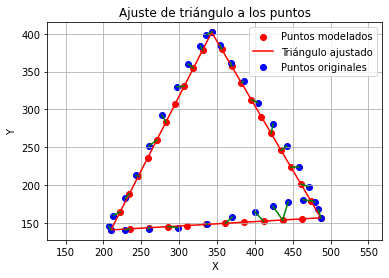

Semejanza: 0.6545081042762456


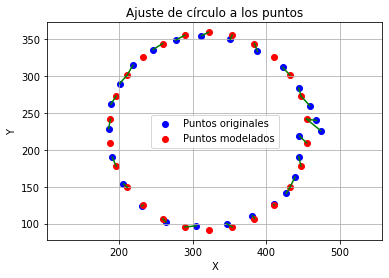

Semejanza: 0.7594109562481385


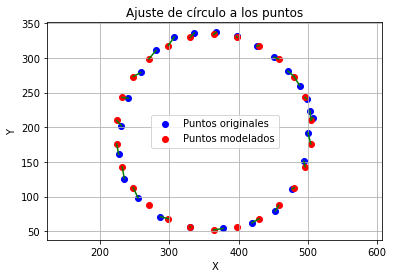

In [9]:
cap = cv2.VideoCapture(0)

frame_width = 1280
frame_height = 720
cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)

stop_detection = False
prev_frame_time = 0
new_frame_time = 0

while not stop_detection:

    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)

    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time) if new_frame_time != prev_frame_time else 0
    prev_frame_time = new_frame_time
    cv2.putText(frame, f"FPS: {fps:.2f}", (450, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    if detectar_octogono(frame):
        stop_detection = True
        break

    tracking_positions = []
    tracking_started = False
    start_time = None
    initial_position = None

    circle_found = False
    triangle_found = False
    while not circle_found and not triangle_found:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)

        new_frame_time = time.time()
        fps = 1 / (new_frame_time - prev_frame_time) if new_frame_time != prev_frame_time else 0
        prev_frame_time = new_frame_time
        cv2.putText(frame, f"FPS: {fps:.2f}", (450, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        circle_found = detectar_circulo(frame)
        triangle_found = detectar_triangulo(frame)

        if detectar_octogono(frame):
            stop_detection = True
            break

        cv2.imshow('Seguimiento de Luz', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            stop_detection = True
            break
        
    if not stop_detection:
        # Mostrar cuenta atrás antes de iniciar el seguimiento
        for i in range(4, 0, -1):
            for j in range(10):
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.flip(frame, 1)  # Invertir la imagen

                new_frame_time = time.time()
                fps = 1 / (new_frame_time - prev_frame_time) if new_frame_time != prev_frame_time else 0
                prev_frame_time = new_frame_time
                cv2.putText(frame, f"FPS: {fps:.2f}", (450, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

                cv2.putText(frame, f"Comienza en {i}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                cv2.imshow('Seguimiento de Luz', frame)
                cv2.waitKey(100)

    show_similarity_score = False
    similarity_score = None
    score_display_start_time = None
    valid_shape = False

    while not stop_detection:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)

        new_frame_time = time.time()
        fps = 1 / (new_frame_time - prev_frame_time) if new_frame_time != prev_frame_time else 0
        prev_frame_time = new_frame_time
        cv2.putText(frame, f"FPS: {fps:.2f}", (450, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        if show_similarity_score:
            elapsed_display_time = time.time() - score_display_start_time
            elapsed_time = 0
            if elapsed_display_time < 5:
                if valid_shape:
                    cv2.putText(frame, f"Semejanza: {similarity_score:.2f}", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                else:
                    cv2.putText(frame, "Forma incorrecta. Intente de nuevo", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            else:
                show_similarity_score = False
                valid_shape = False
                break
        else:
            detected = detect_bright_object(frame)
            if detected:
                measured = np.array([[np.float32(detected[0])], [np.float32(detected[1])]])
                kalman.correct(measured)

                if not tracking_started:
                    tracking_started = True
                    start_time = time.time()
                    initial_position = detected

            predicted = kalman.predict()
            predicted_x, predicted_y = int(predicted[0].item()), int(predicted[1].item())

            if detected:
                cv2.circle(frame, detected, 10, (0, 255, 0), 2)
                if tracking_started:
                    tracking_positions.append(detected)

            for i in range(1, len(tracking_positions)):
                cv2.line(frame, tracking_positions[i - 1], tracking_positions[i], (0, 0, 255), 2)

            cv2.circle(frame, (predicted_x, predicted_y), 10, (255, 0, 0), 2)
            elapsed_time = time.time() - start_time if tracking_started else 0
            cv2.putText(frame, f"Tiempo transcurrido: {elapsed_time:.2f} s", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        if tracking_started and elapsed_time > 1:
            if elapsed_time > 6:
                print("Demasiado lento")
                valid_shape = False
                show_similarity_score = True
                score_display_start_time = time.time()
                
            if detected and initial_position and euclidean_distance(detected, initial_position) < 40:
                if elapsed_time < 2:
                    print("Demasiado rápido")
                    valid_shape = False
                    show_similarity_score = True
                    score_display_start_time = time.time()
                    
                #Eliminar puntos duplicados o muy parecidos
                tracking_positions = [tracking_positions[i] for i in range(len(tracking_positions))
                                    if i == 0 or euclidean_distance(tracking_positions[i], tracking_positions[i - 1]) > 3]


                #ELIMINAR ESTO LUEGO
                for i in range(len(tracking_positions)):
                    tracking_positions[i] = (tracking_positions[i][0], abs(tracking_positions[i][1]-479))

                if circle_found:
                    circulo = ajustar_circulo(tracking_positions)
                    if circulo[2] < 125:
                        print("Círculo demasiado pequeño")
                        valid_shape = False
                        show_similarity_score = True
                        score_display_start_time = time.time()
                    else:
                        if not show_similarity_score:
                            puntos_circulo = generar_puntos_circulo(circulo[0], circulo[1], circulo[2], len(tracking_positions))
                            semejanza, puntos_unidos = calcular_semejanza_circulo(tracking_positions, puntos_circulo, circulo[2])
                            print("Semejanza:", semejanza)

                            similarity_score = semejanza
                            show_similarity_score = True
                            score_display_start_time = time.time()
                            valid_shape = True
                            plot_circulo(tracking_positions, puntos_circulo, puntos_unidos)

                elif triangle_found:
                    vertices = ajustar_triangulo(tracking_positions)
                    if euclidean_distance(vertices[0], vertices[1]) < 50:
                        print("Triángulo demasiado pequeño")
                        valid_shape = False
                        show_similarity_score = True
                        score_display_start_time = time.time()
                    else:
                        if not show_similarity_score:
                            puntos_triangulo = generar_puntos_triangulo(vertices, len(tracking_positions))
                            semejanza, puntos_unidos = calcular_semejanza_triangulo(tracking_positions, puntos_triangulo)
                            print("Semejanza:", semejanza)

                            similarity_score = semejanza
                            show_similarity_score = True
                            score_display_start_time = time.time()
                            valid_shape = True
                            plot_triangulo(tracking_positions, puntos_triangulo, puntos_unidos)

        cv2.imshow('Seguimiento de Luz', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            stop_detection = True
            break


cap.release()
cv2.destroyAllWindows()
